# Laboratorio di Simulazione Numerica: lezione 10

Elia Steve, 47122A

In [1]:
import sys
sys.path.append("..") #To import my python module

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from lib_NSL_py.tsp import plot_network, create_graph, compute_cycle_length

### Esercizi 10.1 e 10.2

In questi esercizi dobbiamo parallellizzare il codice della lezione 9 che implementa l'algoritmo genetico per risolvere il problema del commesso viaggiatore. In particolare ho scelto di implementare la ricerca genetica, dove molteplici nodi (i _continenti_) eseguono in parallelo un'ottimizzazione tramite algoritmo genetico, scambiandosi periodicamente i propri individui migliori. Le principali modifiche al codice dell'esercizio 9 sono le seguenti.

* _Migrazione._ Ogni $N_\mathrm{migr}$ iterazioni (io ho scelto $N_\mathrm{migr}=200$) ciascun nodo sopprime i propri 5 individui peggiori e riceve i 5 individui migliori di un altro nodo. Per decidere fra quali nodi avviene lo scambio si genera con probabilità uniforme una permutazione degli identificatori dei nodi: ciascun nodo manda i propri individui al nodo che lo segue nella permutazione (l'ultimo elemento manda al primo), e di conseguenza riceve individui da quello che lo precede.
* _Condizione di uscita._ La presenza della migrazione può generare il problema in cui un nodo cerca di ricevere individui da uno che ha già terminato l'esecuzione dell'algoritmo genetico, bloccando il programma: per ovviare a questo problema ho deciso di far terminare tutti i nodi simultaneamente. Il programma quindi termina una volta che sono state effettuate (da tutti i nodi) un numero fisso $n$ di iterazioni (io ho scelto $n=200000$ iterazioni) oppure secondo la seguente prescrizione. Ogni nodo imposta a vero una variabile booleana una volta che ha effettuato un numero fisso $n'$ di iterazioni senza avere miglioramenti nella funzione costo della popolazione (io ho scelto $n'=10000$ iterazioni): ad ogni iterazione i nodi si comunicano il prodotto logico delle proprie variabili, e quando tutte sono impostate a vero tutti i nodi terminano simultaneamente.

Alla fine dell'ottimizzazione si prende come risultato della ricerca genetica il miglior individuo fra quelli ottenuti dai singoli nodi.

Ho eseguito l'algoritmo su 11 nodi (sulle macchine del laboratorio).

#### Risultati

Carico i dati:

In [3]:
n_nodes = 11

In [4]:
cities = np.loadtxt("cap_prov_ita.dat")
best_path = np.loadtxt("best_individual.dat", skiprows=1, dtype=int)
best_path = np.append(best_path, 0)
best_path_NM = np.loadtxt("best_individual_nomigr.dat", skiprows=1, dtype=int)
best_path_NM = np.append(best_path_NM, 0)

Disegno un grafico del numero di iterazioni impiegato dai vari algoritmi per raggiungere la soluzione finale:

In [5]:
def read_iterations_from_file(filename):
    string = ""
    with open(filename) as f:
        for line in f:
            string = line
        string = string.strip().split()
    return int(string[2])

In [6]:
label = ["Nodi con migrazione"]
value = [read_iterations_from_file("node0_output.txt")]
colors = ["tab:orange"]
for i in range(n_nodes):
    label.append("Nodo " + str(i) + " (no m.)")
    value.append(read_iterations_from_file("node" + str(i) + "_output_nomigr.txt"))
    colors.append("tab:blue")

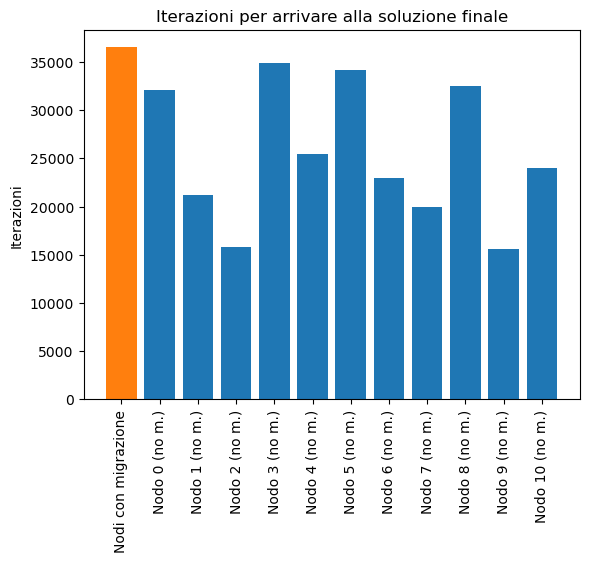

In [7]:
plt.bar(label, value, color=colors)
plt.xticks(label, label, rotation=90)
plt.ylabel("Iterazioni")
plt.title("Iterazioni per arrivare alla soluzione finale")
plt.show()

Qui vediamo che l'algoritmo con migrazione converge alla soluzione ottimale in circa 25000 iterazioni (dopo le quali compie ancora ~10000 iterazioni), e che i nodi nell algoritmo con ricerche parallele senza migrazione impiegano un numero di iterazioni che va da qualche migliaio a qualche decina di migliaia (che è confrontabile con il caso con migrazioni).

Disegno i grafici delle soluzioni nel caso con e senza migrazioni:

In [8]:
best_sol_NM = create_graph(cities, best_path_NM)

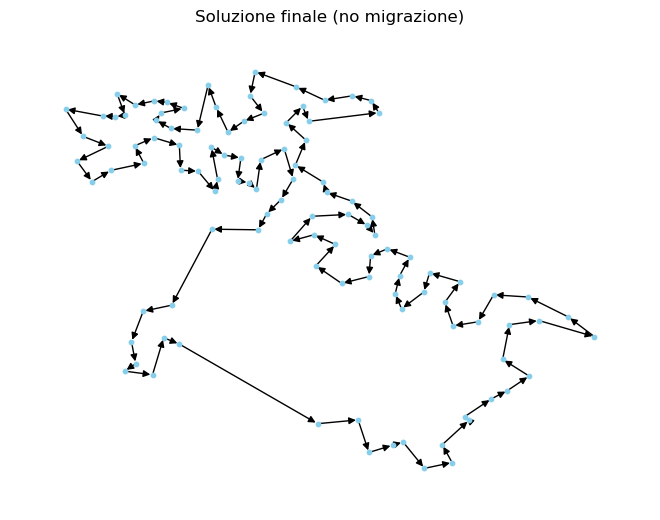

In [9]:
plot_network(best_sol_NM, "Soluzione finale (no migrazione)")

In [10]:
print("Lunghezza (L^1, no migrazione):", compute_cycle_length(best_sol_NM, best_path_NM))

Lunghezza (L^1, no migrazione): 66.88844333395507


In [11]:
best_sol = create_graph(cities, best_path)

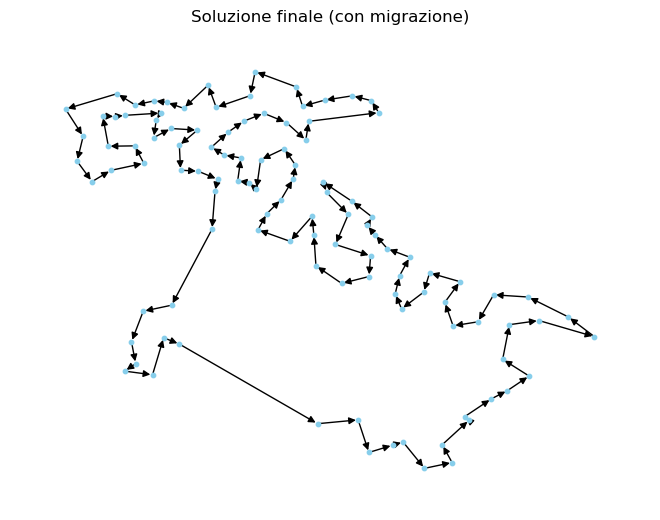

In [12]:
plot_network(best_sol, "Soluzione finale (con migrazione)")

In [13]:
print("Lunghezza (L^1, con migrazione):", compute_cycle_length(best_sol, best_path))

Lunghezza (L^1, con migrazione): 66.6583323688615


Vediamo che l'introduzione delle migrazioni rispetto alla sola ricerca parallela provoca un miglioramento della soluzione (anche se non enorme: sperimentando ho osservato che per altri semi dei generatori di numeri casuali il miglioramento è più netto).